### This file is a playground for developing some functions and checking them before putting them in the .py files

In [1]:
# import all files from necessary directory
from os import listdir, path
dir = "/data/Riabova/train/resized_train/"
all_files = [path.join(dir, f) for f in listdir(dir)]
len(all_files)

95

In [2]:
all_files[0]

'/data/Riabova/train/resized_train/15_0_-9_0_0_0_4_2_1689849046042619.hdf5'

In [ ]:
import numpy as np
import h5py
# merge all images in one huge array

all_frames_filenames_array = np.empty((1))
frame_nums = np.empty((1))
i = 0
for f in all_files:
    if (i%20 == 0):
        print("File "+str(i)+"...")
    h5_file = h5py.File(f, 'r')
    framesTotal = sum(item.startswith('img_') for item in list(h5_file.keys()))//11
    h5_file.close()
    all_frames_filenames_array = np.concatenate((all_frames_filenames_array, [f]*framesTotal), axis=0)
    frame_nums = np.concatenate((frame_nums, np.arange(0, framesTotal)), axis=0)
    i+=1

In [4]:
all_frames_filenames_array = all_frames_filenames_array[1:]
frame_nums = frame_nums[1:]

X = np.vstack((all_frames_filenames_array, frame_nums)).transpose()
print(X.shape)
print(X[0, :])

(1730, 2)
['/data/Riabova/train/resized_train/15_0_-9_0_0_0_4_2_1689849046042619.hdf5'
 '0.0']


In [11]:
VALID_PERCENT = 0.2
TEST_PERCENT = 0.2
BATCH_TRAIN = 24
BATCH_VALID = 24
BATCH_TEST = 24
# note: original size - 235; resizing to 200 + batch size 5 caused cuda out of memory

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_vt = train_test_split(X[:, :], test_size=VALID_PERCENT+TEST_PERCENT, random_state=42, shuffle = True)
X_valid, X_test = train_test_split(X_vt[:, :], test_size=TEST_PERCENT/(VALID_PERCENT+TEST_PERCENT), random_state=42,shuffle=True)
print(f"Total training images: {X_train.shape[0]}")
print(f"Total validation images: {X_valid.shape[0]}")
print(f"Total test images: {X_test.shape[0]}")


Total training images: 1038
Total validation images: 346
Total test images: 346


In [13]:
from utils.datasets import CustomMaskDataset, my_collate
import torch

train_dataset = CustomMaskDataset(X_train, maskType='full')
valid_dataset = CustomMaskDataset(X_valid, maskType='full')
test_dataset = CustomMaskDataset(X_test, maskType='full')
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_TRAIN,shuffle=True, collate_fn=my_collate)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset,batch_size=BATCH_VALID,shuffle=True, collate_fn=my_collate)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=BATCH_TEST,shuffle=True, collate_fn=my_collate)

In [14]:
# Check if all elements of dataset contain original labels
print("Whole dataset contains "+str(len(X))+" frames")

itemsWithLabelsResizedKey = 0
for x in X:
    f = x[0]
    h5_file = h5py.File(f, 'r')
    if 'labels_original' in list(h5_file.keys()):
        itemsWithLabelsResizedKey = itemsWithLabelsResizedKey+1
    h5_file.close()
print("The dataset items, containing corresponding original labels: "+str(itemsWithLabelsResizedKey)+" frames")

Whole dataset contains 1730 frames
The dataset items, containing corresponding original labels: 1730 frames


In [ ]:
# To check the speed of accessing data. 
# Result for batch size=10: 2s/batch
# Result for batch size=24: 5s/batch
from tqdm import tqdm
for sample in tqdm(iter(train_dataloader)):
    print(sample['image'].shape)

### plot 3 different masks and original image next to each other

In [18]:
import h5py

maskRadius = 3

idx = 10

f = X[idx, 0]
transformNum = 10
frameNumInt = int(float(X[idx, 1]))
frameNumStr = str(frameNumInt)
h5_file = h5py.File('../train/resized_train/'+f+'.hdf5', 'r')
img = h5_file["img"+"_"+frameNumStr+"_"+str(transformNum)][()]
img2 = h5_file["img"+"_"+str(frameNumInt-2)+"_"+str(transformNum)][()]
tip_coords = h5_file["labels"+"_"+frameNumStr+"_"+str(transformNum)][()]
mask_full_2 = h5_file["mask"+"_"+str(frameNumInt-2)+"_"+str(transformNum)][()]
tip_coords_original = h5_file["labels_original"][frameNumInt, :]

mask_full = h5_file["mask"+"_"+frameNumStr+"_"+str(transformNum)][()]
mask_tip = np.zeros((img.shape))
mask_tip[np.around(tip_coords[0]-maskRadius).astype(int):np.around(tip_coords[0]+maskRadius).astype(int), 
            np.around(tip_coords[1]-maskRadius).astype(int):np.around(tip_coords[1]+maskRadius).astype(int), 
            np.around(tip_coords[2]-maskRadius).astype(int):np.around(tip_coords[2]+maskRadius).astype(int)
        ] = 1
mask_diff = mask_full - mask_full_2
h5_file.close()



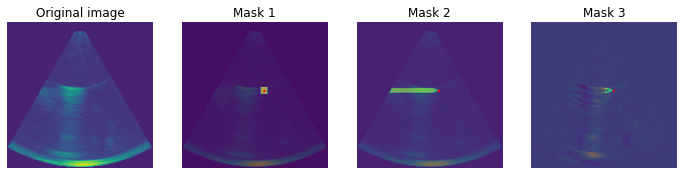

In [32]:
from matplotlib import pyplot as plt, patches

fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(1, 4, 1)
plt.imshow(img[:, :, int(tip_coords[2])].T)
ax.set_title("Original image")
plt.axis('off')


ax = fig.add_subplot(1, 4, 2)
plt.imshow(img[:, :, int(tip_coords[2])].T)
plt.imshow(mask_tip[:, :, int(tip_coords[2])].T, alpha=0.6)
ax.add_patch(patches.Circle((int(tip_coords[0]), int(tip_coords[1])), radius=0.5, color='red'))
ax.set_title("Mask 1")
plt.axis('off')


ax = fig.add_subplot(1, 4, 3)
plt.imshow(img[:, :, int(tip_coords[2])].T)
plt.imshow(mask_full[:, :, int(tip_coords[2])].T, alpha=0.6)
ax.add_patch(patches.Circle((int(tip_coords[0]), int(tip_coords[1])), radius=0.5, color='red'))
ax.set_title("Mask 2")
plt.axis('off')


ax = fig.add_subplot(1, 4, 4)
plt.imshow(img[:, :, int(tip_coords[2])].T - img2[:, :, int(tip_coords[2])].T)
plt.imshow(mask_full[:, :, int(tip_coords[2])].T-mask_full_2[:, :, int(tip_coords[2])].T, alpha=0.7)
ax.add_patch(patches.Circle((int(tip_coords[0]), int(tip_coords[1])), radius=0.5, color='red'))
ax.set_title("Mask 3")
plt.axis('off')

plt.show()

### plot two frames from one sequence next to each other with needle pixels and tip ground truth:

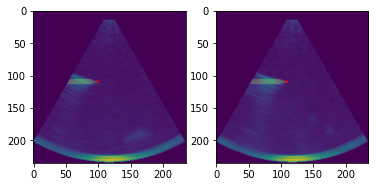

In [ ]:
import h5py
import matplotlib.pyplot as plt
from utils.type_reader import get_image_array
from matplotlib import patches


input_image = get_image_array(X[0][0])
h5_file = h5py.File('../train/needle_masks_h5/'+X[0][0][:-4].split("/")[-1]+'.hdf5', 'r')
needle_mask = h5_file['default'][()]
h5_file.close()

frame_first = 0
frame_second = 3
label_first = labels[frame_first]
label_second = labels[frame_second]

fig = plt.figure()

ax = fig.add_subplot(1, 2, 1)
plt.imshow(input_image[:, :, int(label_first[2]), frame_first].T)
plt.imshow(needle_mask[frame_first, :, :, int(label_first[2])].T, alpha=0.2)
ax.add_patch(patches.Circle((int(label_first[0]), int(label_first[1])), radius=1, color='red'))

ax = fig.add_subplot(1, 2, 2)
plt.imshow(input_image[:, :, int(label_second[2]), frame_second].T)
plt.imshow(needle_mask[frame_second, :, :, int(label_second[2])].T, alpha=0.2)
ax.add_patch(patches.Circle((int(label_second[0]), int(label_second[1])), radius=1, color='red'))

plt.show()

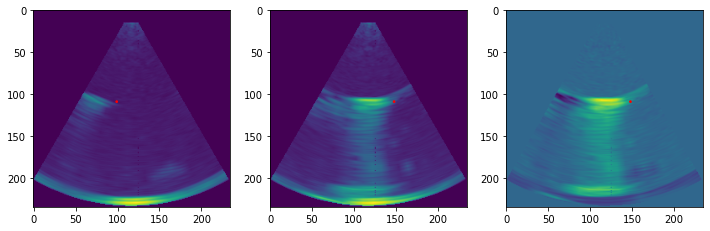

In [ ]:
fig = plt.figure(figsize=(15, 15))

ax = fig.add_subplot(1, 3, 1)
plt.imshow(input_image[:, :, int(label_first[2]), frame_first].T)
#plt.imshow(needle_mask[frame_first, :, :, int(label_first[2])].T, alpha=0.2)
ax.add_patch(patches.Circle((int(label_first[0]), int(label_first[1])), radius=1, color='red'))

ax = fig.add_subplot(1, 3, 2)
plt.imshow(input_image[:, :, int(label_second[2]), frame_second].T)
#plt.imshow(needle_mask[frame_second, :, :, int(label_second[2])].T, alpha=0.2)
ax.add_patch(patches.Circle((int(label_second[0]), int(label_second[1])), radius=1, color='red'))


ax = fig.add_subplot(1, 3, 3)
plt.imshow(input_image[:, :, int(label_first[2]), frame_first].T)
#plt.imshow(needle_mask[frame_first, :, :, int(label_first[2])].T-needle_mask[frame_second, :, :, int(label_second[2])].T, alpha=0.3)
ax.add_patch(patches.Circle((int(label_second[0]), int(label_second[1])), radius=1, color='red'))
plt.show()

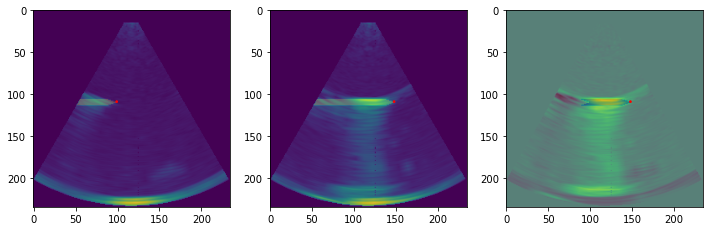

In [ ]:
fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(1, 3, 1)
plt.imshow(input_image[:, :, int(label_first[2]), frame_first].T)
plt.imshow(needle_mask[frame_first, :, :, int(label_first[2])].T, alpha=0.2)
ax.add_patch(patches.Circle((int(label_first[0]), int(label_first[1])), radius=1, color='red'))


ax = fig.add_subplot(1, 3, 2)
plt.imshow(input_image[:, :, int(label_second[2]), frame_second].T)
plt.imshow(needle_mask[frame_second, :, :, int(label_second[2])].T, alpha=0.2)
ax.add_patch(patches.Circle((int(label_second[0]), int(label_second[1])), radius=1, color='red'))


ax = fig.add_subplot(1, 3, 3)
plt.imshow(input_image[:, :, int(label_second[2]), frame_second].T - input_image[:, :, int(label_first[2]), frame_first].T)
plt.imshow(needle_mask[frame_first, :, :, int(label_first[2])].T-needle_mask[frame_second, :, :, int(label_second[2])].T, alpha=0.2)
ax.add_patch(patches.Circle((int(label_second[0]), int(label_second[1])), radius=1, color='red'))

plt.show()

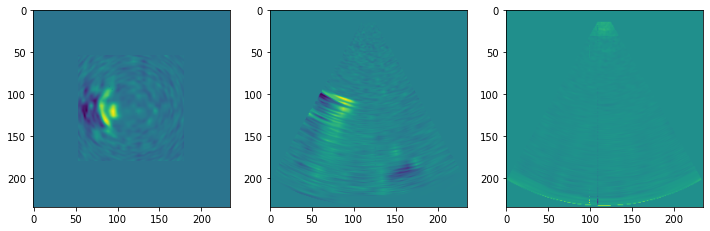

In [ ]:
fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(1, 3, 1)
plt.imshow(input_image[:, int(label_second[1]), :, frame_second].T - input_image[:, int(label_first[1]), :, frame_first].T)


ax = fig.add_subplot(1, 3, 2)
plt.imshow(input_image[:, :, int(label_second[2]), frame_second].T - input_image[:, :, int(label_first[2]), frame_first].T)



ax = fig.add_subplot(1, 3, 3)
plt.imshow(input_image[int(label_second[0]), :, :, frame_second] - input_image[int(label_first[0]), :, :, frame_first])
plt.show()

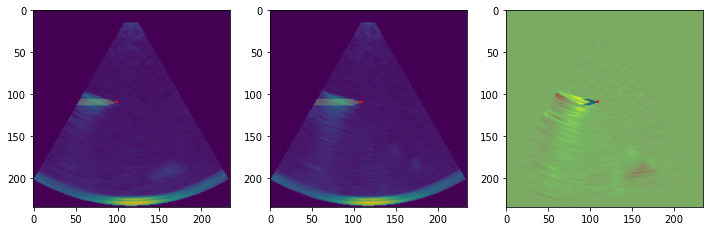

In [ ]:
frame_first = 0
frame_second = 3
label_first = labels[frame_first]
label_second = labels[frame_second]

fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(1, 3, 1)
plt.imshow(input_image[:, :, int(label_first[2]), frame_first].T)
plt.imshow(needle_mask[frame_first, :, :, int(label_first[2])].T, alpha=0.2)
ax.add_patch(patches.Circle((int(label_first[0]), int(label_first[1])), radius=1, color='red'))

ax = fig.add_subplot(1, 3, 2)
plt.imshow(input_image[:, :, int(label_second[2]), frame_second].T)
plt.imshow(needle_mask[frame_second, :, :, int(label_second[2])].T, alpha=0.2)
ax.add_patch(patches.Circle((int(label_second[0]), int(label_second[1])), radius=1, color='red'))


ax = fig.add_subplot(1, 3, 3)
plt.imshow(input_image[:, :, int(label_second[2]), frame_second].T - input_image[:, :, int(label_first[2]), frame_first].T)
plt.imshow(needle_mask[frame_first, :, :, int(label_first[2])].T-needle_mask[frame_second, :, :, int(label_second[2])].T, alpha=0.4)
ax.add_patch(patches.Circle((int(label_second[0]), int(label_second[1])), radius=1, color='red'))
plt.show()

### Create an animation from one sequence of images with needle pixels and tip ground truth and save it:

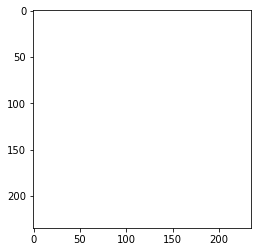

In [ ]:

import matplotlib.animation as anm

img = [] # some array of images
frames_seq = [] # for storing the generated images

fig = plt.figure()
ax = fig.add_subplot()

for i in range(needle_mask.shape[0]):
    frames_seq.append([
        plt.imshow(input_image[:, :, int(labels[i][2]), i].T), 
        plt.imshow(needle_mask[i, :, :, int(labels[i][2])].T, alpha=0.2),
        ax.add_patch(patches.Circle((int(labels[i][0]), int(labels[i][1])), radius=1, color='red'))
])

ani = anm.ArtistAnimation(fig, frames_seq)
ani.save('needle_movement.mp4')

### Check how to determine center of the predicted mask

In [2]:
from utils.mask_utils import get_center_of_nonzero_4d_slice
import torch
import numpy as np

mask_start = np.zeros((1, 5, 5, 5))
mask_start[0, 3:5, 3:5, 3:5] = 1
mask_start[0, 1, 0, 0] = 1
mask_start[0, 0, 2, 0] = 1

get_center_of_nonzero_4d_slice(torch.Tensor(mask_start))

(3.5, 3.5, 3.5)

### Check the frame diff dataset - whether everything loads correctly + whether labels are correct

In [1]:
# import all files from necessary directory
from os import listdir, path
dir = "/data/Riabova/train/resized_train/"
all_files = [path.join(dir, f) for f in listdir(dir)]
len(all_files)

98

In [2]:
FRAME_DIFF = 2

In [ ]:
import numpy as np
import h5py
# merge all images in one huge array

all_frames_filenames_array = np.empty((1))
frame_nums = np.empty((1))
frame_nums_next = np.empty((1))
i = 0
for f in all_files:
    if (i%20 == 0):
        print("File "+str(i)+"...")
    h5_file = h5py.File(f, 'r')
    framesTotal = sum(item.startswith('img_') for item in list(h5_file.keys()))//11
    h5_file.close()
    all_frames_filenames_array = np.concatenate((all_frames_filenames_array, [f]*(framesTotal-FRAME_DIFF)), axis=0)
    frame_nums = np.concatenate((frame_nums, np.arange(0, framesTotal-FRAME_DIFF)), axis=0)
    frame_nums_next = np.concatenate((frame_nums_next, np.arange(FRAME_DIFF, framesTotal)), axis=0)
    i+=1

In [4]:
all_frames_filenames_array = all_frames_filenames_array[1:]
frame_nums = frame_nums[1:]
frame_nums_next = frame_nums_next[1:]

X = np.vstack((all_frames_filenames_array, frame_nums, frame_nums_next)).transpose()
print(X.shape)
print(X[10, :])

(1378, 3)
['/data/Riabova/train/resized_train/15_0_-9_0_0_0_4_2_1689849046042619.hdf5'
 '10.0' '12.0']


In [5]:
VALID_PERCENT = 0.2
TEST_PERCENT = 0.2
BATCH_TRAIN = 24
BATCH_VALID = 24
BATCH_TEST = 24
# note: original size - 235; resizing to 200 + batch size 5 caused cuda out of memory

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_vt = train_test_split(X[:, :], test_size=VALID_PERCENT+TEST_PERCENT, random_state=42, shuffle = True)
X_valid, X_test = train_test_split(X_vt[:, :], test_size=TEST_PERCENT/(VALID_PERCENT+TEST_PERCENT), random_state=42,shuffle=True)
print(f"Total training images: {X_train.shape[0]}")
print(f"Total validation images: {X_valid.shape[0]}")
print(f"Total test images: {X_test.shape[0]}")

Total training images: 826
Total validation images: 276
Total test images: 276


In [7]:
from utils.datasets import FrameDiffDataset, my_collate
import torch

train_dataset = FrameDiffDataset(X_train)
valid_dataset = FrameDiffDataset(X_valid)
test_dataset = FrameDiffDataset(X_test)
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_TRAIN,shuffle=True, collate_fn=my_collate)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset,batch_size=BATCH_VALID,shuffle=True, collate_fn=my_collate)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=BATCH_TEST,shuffle=True, collate_fn=my_collate)

In [81]:
# To check the labels
# To check the speed of accessing data. Result for batch size=24: 8s/batch
from tqdm import tqdm
for sample in tqdm(iter(train_dataloader)):
    print(sample['image'].shape)
    break

  0%|          | 0/35 [00:07<?, ?it/s]

torch.Size([24, 1, 128, 128, 128])


In [82]:
sample_first = {'image':sample['image'][0],'mask':sample['mask'][0],'label':sample['label'][0].int() }

In [84]:
np.count_nonzero(sample['mask'][0].detach().numpy())

59

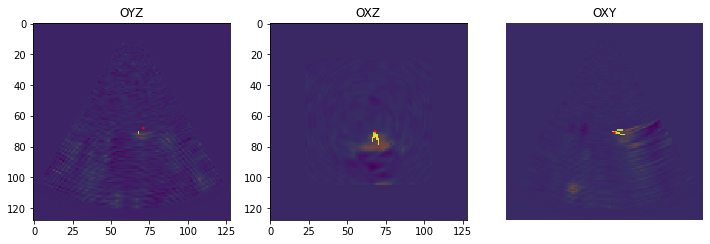

In [85]:
from utils.display_utils import show_sample
from matplotlib import pyplot as plt, patches

fig = plt.figure(figsize=(12, 12))
sample = sample_first
    
x = sample['label'][0].int()
y = sample['label'][1].int()
z = sample['label'][2].int()

ax1 = fig.add_subplot(1, 3, 1)
plt.title("OYZ")
plt.imshow(sample['image'][0, x, :, :], interpolation='none')
plt.imshow(sample['mask'][0, x, :, :], interpolation='none', alpha = 0.7)
ax1.add_patch(patches.Circle((y, z), radius=0.5, color='red'))


ax2 = fig.add_subplot(1, 3, 2)
plt.title("OXZ")
plt.imshow(sample['image'][0, :, y, :], interpolation='none')
plt.imshow(sample['mask'][0, :, y, :], interpolation='none', alpha = 0.7)
ax2.add_patch(patches.Circle((z, x), radius=0.5, color='red'))


ax3 = fig.add_subplot(1, 3, 3)
plt.title("OXY")
plt.imshow(sample['image'][0, :, :, z].T, interpolation='none')
plt.imshow(sample['mask'][0, :, :, z].T, interpolation='none', alpha = 0.7)
ax3.add_patch(patches.Circle((x, y), radius=0.5, color='red'))

plt.axis('off')
plt.show()

### Add labels_original to the files where its missing

In [2]:
import numpy as np
import h5py
from utils.type_reader import mha_read_header
from utils.labels_utils import get_labels
from os import listdir, path

dir = "/data/Riabova/train/resized_train/"
all_files = [path.join(dir, f) for f in listdir(dir)]
len(all_files)

i=0
dirMHD = "/data/Riabova/train/train_depth_0_70/"
f = '/data/Riabova/train/resized_train/15_0_-9_0_0_0_4_2_1689849046042619.hdf5'
h5_file = h5py.File(f, 'a')
f_mhd = dirMHD+f[:-5].split("/")[-1]+'.mhd'
info = mha_read_header(f_mhd)
labels = get_labels(f[:-5].split("/")[-1], info)
h5_file.create_dataset("labels_original_new", data=labels)
h5_file.close()

### Binarize all resized masks, because during resizing used wrond interpolation and now they are non-binary (<font color='red'>L</font><font color='orange'>G</font><font color='yellow'>B</font><font color='green'>T</font><font color='blue'>Q</font><font color='purple'>+</font>)

In [2]:
import numpy as np
import h5py
from utils.type_reader import mha_read_header
from utils.labels_utils import get_labels
from os import listdir, path

dir = "/data/Riabova/train/resized_train/"
all_files = [path.join(dir, f) for f in listdir(dir)]
len(all_files)

i=0
for f in all_files:
    if (i%20 == 0):
        print("File "+str(i)+"...")
    h5_file = h5py.File(f, 'r+')
    resizedMaskKeys = [key for key in list(h5_file.keys()) if key.startswith("mask") & key.endswith("10")]
    for key in resizedMaskKeys:
        previous_mask = h5_file[key][()]
        h5_file[key][...] =(previous_mask>0.5).astype(int)
    h5_file.close()
    i+=1

File 0...
File 20...
File 40...
File 60...
File 80...
File 100...


In [4]:
import h5py
import os

directory = '/data/Riabova/train/resized_train'

for filename in os.listdir(directory):
    if filename.endswith('.hdf5') or filename.endswith('.h5'):
        fullpath = os.path.join(directory, filename)
        f = h5py.File(fullpath, 'a')
        if ("labels_original_new" not in f.keys()):
            print(f)
        f.close()

### Go over all saved models in the directory and recompute validation loss

In [12]:
from os import listdir, path
import numpy as np
import h5py

dir = "/data/Riabova/train/resized_train/"
all_files = [path.join(dir, f) for f in listdir(dir)]
all_frames_filenames_array = np.empty((1))
frame_nums = np.empty((1))
i = 0
for f in all_files:
    if (i%20 == 0):
        print("File "+str(i)+"...")
    h5_file = h5py.File(f, 'r')
    framesTotal = sum(item.startswith('img_') for item in list(h5_file.keys()))//11
    h5_file.close()
    all_frames_filenames_array = np.concatenate((all_frames_filenames_array, [f]*framesTotal), axis=0)
    frame_nums = np.concatenate((frame_nums, np.arange(0, framesTotal)), axis=0)
    i+=1
    
all_frames_filenames_array = all_frames_filenames_array[ 1:]
frame_nums = frame_nums[1:]

X = np.vstack((all_frames_filenames_array, frame_nums)).transpose()
print(X.shape)
print(X[0, :])

File 0...
File 20...
File 40...
File 60...
File 80...
File 100...
(2272, 2)
['/data/Riabova/train/resized_train/15_0_-9_0_0_0_4_2_1689849046042619.hdf5'
 '0.0']


In [13]:
from sklearn.model_selection import train_test_split
from utils.datasets import CustomMaskDataset, my_collate
import torch

VALID_PERCENT = 0.2
TEST_PERCENT = 0.2
BATCH_TRAIN = 10
BATCH_VALID = 10
BATCH_TEST = 10

X_train, X_vt = train_test_split(X[:, :], test_size=VALID_PERCENT+TEST_PERCENT, random_state=42, shuffle = True)
X_valid, X_test = train_test_split(X_vt[:, :], test_size=TEST_PERCENT/(VALID_PERCENT+TEST_PERCENT), random_state=42,shuffle=True)
print(f"Total training images: {X_train.shape[0]}")
print(f"Total validation images: {X_valid.shape[0]}")
print(f"Total test images: {X_test.shape[0]}")

train_dataset = CustomMaskDataset(X_train, maskType='full')
valid_dataset = CustomMaskDataset(X_valid, maskType='full')
test_dataset = CustomMaskDataset(X_test, maskType='full')
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_TRAIN,shuffle=True, collate_fn=my_collate)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset,batch_size=BATCH_VALID,shuffle=True, collate_fn=my_collate)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=BATCH_TEST,shuffle=True, collate_fn=my_collate)

Total training images: 1363
Total validation images: 454
Total test images: 455


In [1]:
# %%
import torch.nn as nn
import torch
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from models.unet import UNet
from utils.losses import IoULoss
from utils.save_model_utils import SaveBestModel

UNET_DEPTH = 4 # size of the image should divide by this number
UNET_START_FILTERS = 3
INIT_LR = 0.01
PATH_DIR = 'outputs/outputs_new'

# device will be 'cuda' if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = UNet(out_channels = 1, n_blocks=UNET_DEPTH, start_filts = UNET_START_FILTERS).to(device)
optimizer = optim.Adam(model.parameters(), lr = INIT_LR)# optim.RMSprop(model.parameters(),lr=INIT_LR, weight_decay=WEIGHT_DECAY, momentum=MOMENTUM, foreach=True)
criterion = IoULoss()

In [ ]:
model

In [39]:
import matplotlib.pyplot as plt 

all_model_dicts = [path.join(PATH_DIR, f) for f in listdir(PATH_DIR) if f.endswith(".pth") and f.startswith("epoch_")]
validation_loss = []
train_loss = []
tip_distances = []

In [40]:
all_model_dicts_sorted = sorted(all_model_dicts, key=lambda x:  int(x.split("_")[-2]))
all_model_dicts_sorted

['outputs/outputs_new/epoch_10_model.pth',
 'outputs/outputs_new/epoch_20_model.pth',
 'outputs/outputs_new/epoch_30_model.pth',
 'outputs/outputs_new/epoch_40_model.pth',
 'outputs/outputs_new/epoch_50_model.pth',
 'outputs/outputs_new/epoch_60_model.pth',
 'outputs/outputs_new/epoch_70_model.pth',
 'outputs/outputs_new/epoch_80_model.pth',
 'outputs/outputs_new/epoch_90_model.pth',
 'outputs/outputs_new/epoch_100_model.pth',
 'outputs/outputs_new/epoch_110_model.pth',
 'outputs/outputs_new/epoch_120_model.pth',
 'outputs/outputs_new/epoch_130_model.pth',
 'outputs/outputs_new/epoch_140_model.pth',
 'outputs/outputs_new/epoch_150_model.pth',
 'outputs/outputs_new/epoch_160_model.pth',
 'outputs/outputs_new/epoch_170_model.pth',
 'outputs/outputs_new/epoch_180_model.pth',
 'outputs/outputs_new/epoch_190_model.pth',
 'outputs/outputs_new/epoch_200_model.pth']

In [41]:
from utils.accuracies import get_full_mask_tip_pixel_distance

for model_dict_num, model_dict in enumerate(all_model_dicts_sorted):
    state = torch.load(model_dict)
    
    model.load_state_dict(state['model_state_dict'])
    optimizer.load_state_dict(state['optimizer_state_dict'])
    model.eval()  # evaluation mode
    valid_losses = []  # accumulate the losses here
    tip_distances_batch = []
    batch_iter = tqdm(enumerate(valid_dataloader), 'Validation', total=len(valid_dataloader), leave=False)

    for i, sample_batched in batch_iter:
        input, target, labels = sample_batched['image'].to(device), sample_batched['mask'].to(device), sample_batched['label'].to(device)  # send to device (GPU or CPU)

        with torch.no_grad():
            out = model(input)
            loss = criterion(out, target)
            loss_value = loss.item()
            valid_losses.append(loss_value)
            tip_distances_batch.append(get_full_mask_tip_pixel_distance(out, labels))
            batch_iter.set_description(f'Validation: (loss {loss_value:.4f})')

    validation_loss.append(np.mean(valid_losses))
    tip_distances.append(np.mean(tip_distances_batch))
    train_loss.append(state['train_loss'])
    
    # accuracy plots
    plt.figure()
    plt.plot(np.arange(0, model_dict_num+1), validation_loss, color='green', linestyle='-', label='validation loss')
    plt.plot(np.arange(0, model_dict_num+1), train_loss, color='red', linestyle='-', label='train loss')
    plt.title("Losses over epochs")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.xticks(np.arange(0, model_dict_num+1), labels=range(0, (model_dict_num+1)*10, 10)) 
    plt.savefig(PATH_DIR+'/recalc_loss.jpg')
    plt.close()
    
    # accuracy plots
    plt.figure()
    plt.plot(np.arange(0, model_dict_num+1), tip_distances, color='green', linestyle='-')
    plt.title("Distances between between actual and predicted tip position")
    plt.xlabel('Epochs')
    plt.ylabel('Distance, px')
    plt.xticks(np.arange(0, model_dict_num+1), labels=range(0, (model_dict_num+1)*10, 10)) 
    plt.savefig(PATH_DIR+'/tip_distance.jpg')
    plt.close()

    batch_iter.close()


### Try to display intermediate layer outputs of the model

In [14]:
sample_batched = next(iter(train_dataloader))
image = sample_batched['image'][0]
target = sample_batched['mask'][0]
labels = sample_batched['label'][0]
sample = {'label':labels, 'mask':target, 'image':image}

In [ ]:
image = torch.unsqueeze(image, dim=0)
image.shape

In [119]:
# %%
import torch.nn as nn
import torch
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from models.unet import UNet
from utils.losses import IoULoss
from utils.save_model_utils import SaveBestModel

UNET_DEPTH = 4 # size of the image should divide by this number
UNET_START_FILTERS = 3
INIT_LR = 0.01
PATH_DIR = 'outputs/outputs_new'

# device will be 'cuda' if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = UNet(out_channels = 1, n_blocks=UNET_DEPTH, start_filts = UNET_START_FILTERS).to(device)
optimizer = optim.Adam(model.parameters(), lr = INIT_LR)# optim.RMSprop(model.parameters(),lr=INIT_LR, weight_decay=WEIGHT_DECAY, momentum=MOMENTUM, foreach=True)
criterion = IoULoss()

In [120]:
state = torch.load('outputs/outputs_new_full_mask/epoch_200_model.pth')
    
model.load_state_dict(state['model_state_dict'])
optimizer.load_state_dict(state['optimizer_state_dict'])
model.eval()  # evaluation mode
model.to('cuda')

UNet(
  (down_convs): ModuleList(
    (0): DownConv(
      (conv1): Conv3d(1, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (conv2): Conv3d(3, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (act1): ReLU()
      (act2): ReLU()
      (norm0): BatchNorm3d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (norm1): BatchNorm3d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): DownConv(
      (conv1): Conv3d(3, 6, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (conv2): Conv3d(6, 6, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (act1): ReLU()
      (act2): ReLU()
      (norm0): BatchNorm3d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (norm1): BatchNorm3d(6

In [121]:
# placeholder for batch features
features = {}

def getIntermediateOutput(name):
    def hook(model, input, output):
        features[name] = output[0].detach()
    return hook

In [122]:
model.down_convs[0].register_forward_hook(getIntermediateOutput('first_downconv'))
model.down_convs[1].register_forward_hook(getIntermediateOutput('second_downconv'))
model.down_convs[2].register_forward_hook(getIntermediateOutput('third_downconv'))
model.down_convs[3].register_forward_hook(getIntermediateOutput('fourth_downconv'))

In [123]:
out = model(image.to('cuda'))

In [126]:
first_downconv_output = features['first_downconv'].cpu().numpy()
second_downconv_output = features['second_downconv'].cpu().numpy()
third_downconv_output = features['third_downconv'].cpu().numpy()
fourth_downconv_output = features['fourth_downconv'].cpu().numpy()

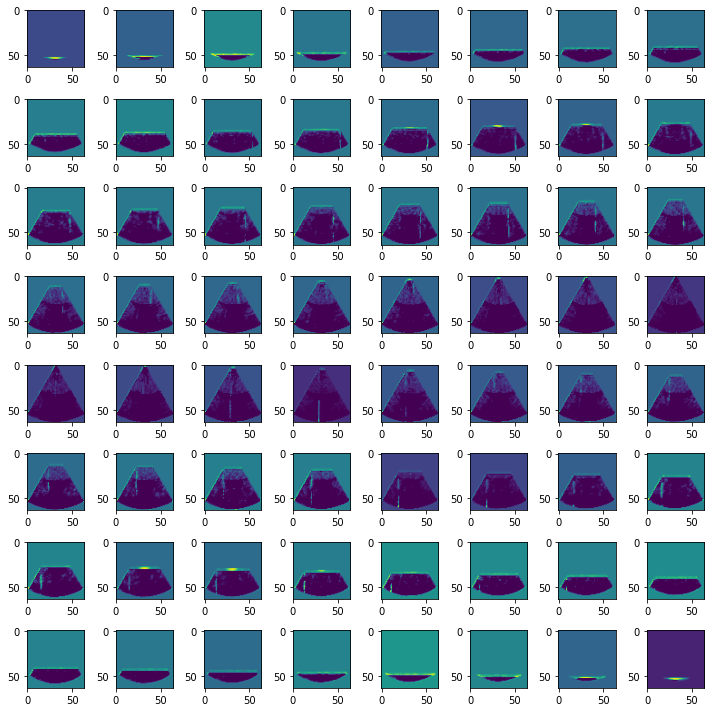

In [141]:
from matplotlib import pyplot as plt

# size of first layer ouput: 3*64*64*64

# Create figure and axes 
fig, axs = plt.subplots(8, 8, figsize=(10,10))
axs = axs.flatten() 

# Plot each data element on subplot
for i, ax in enumerate(axs):
    ax.imshow(first_downconv_output[0, 1, i])

fig.tight_layout()
plt.show()

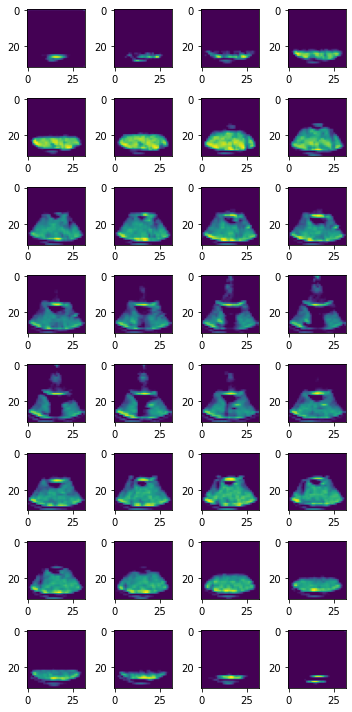

In [159]:
from matplotlib import pyplot as plt

# size of first layer ouput: 6*32*32*32

# Create figure and axes 
fig, axs = plt.subplots(8, 4, figsize=(5,10))
axs = axs.flatten() 

# Plot each data element on subplot
for i, ax in enumerate(axs):
    ax.imshow(second_downconv_output[0, 5, i])

fig.tight_layout()
plt.show()

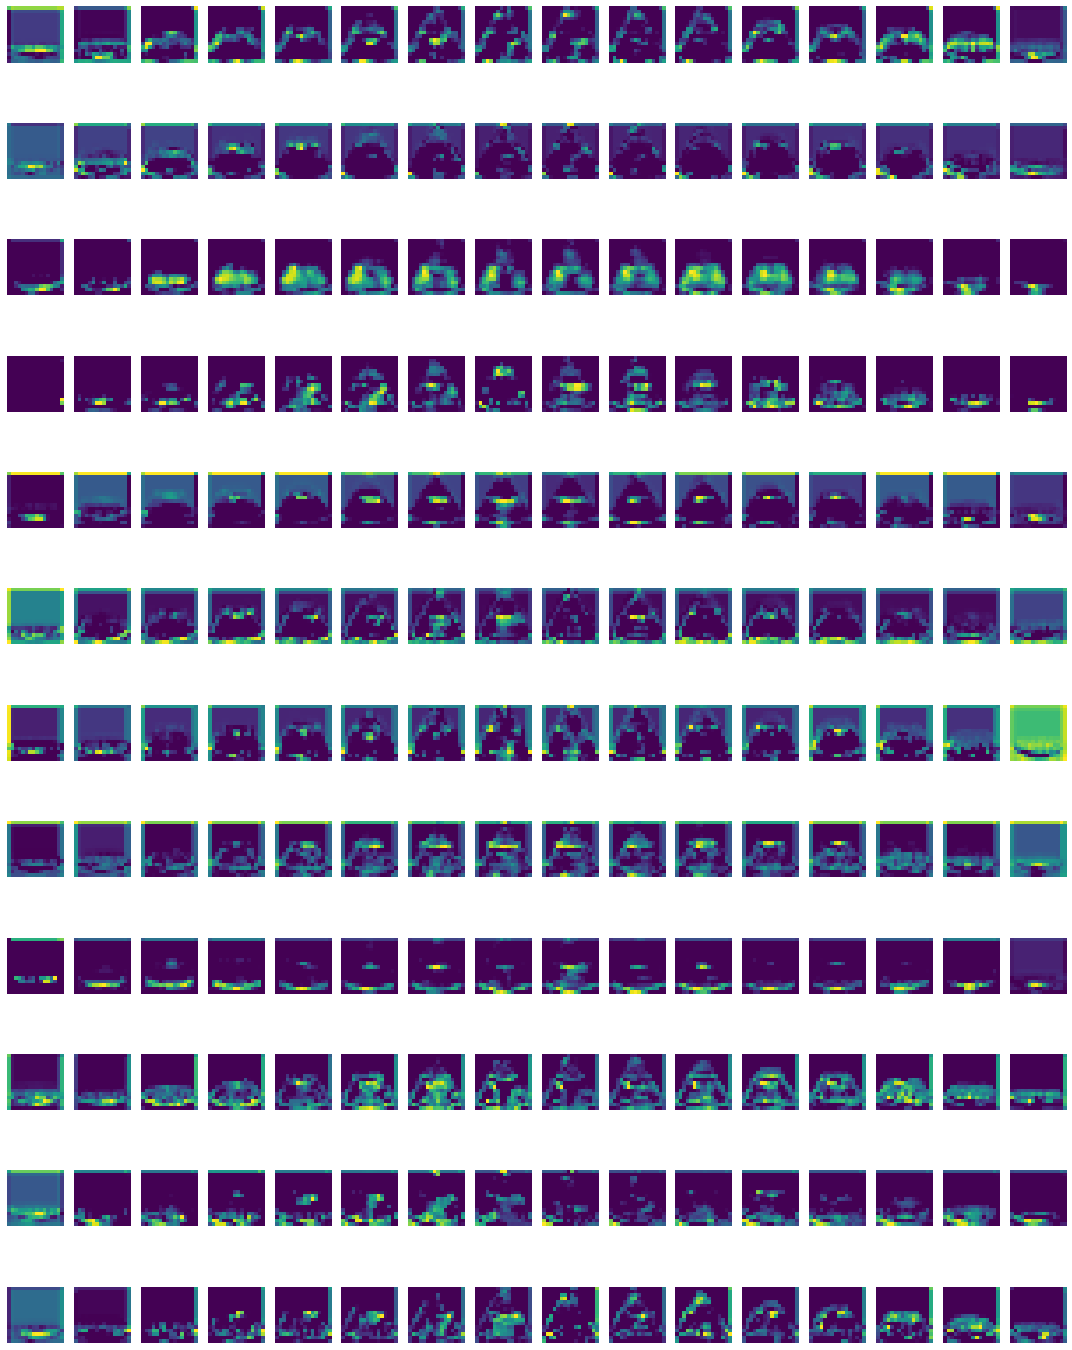

In [163]:
from matplotlib import pyplot as plt

# size of third layer ouput: (12, 16, 16, 16)

# Create figure and axes 
fig, axs = plt.subplots(12, 16, figsize=(15,20))

# Plot each data element on subplot
for i in range(12):
    for j in range(16):
        axs[i,j].imshow(third_downconv_output[0, i, j])
        axs[i,j].axis('off')

fig.tight_layout()
plt.show()

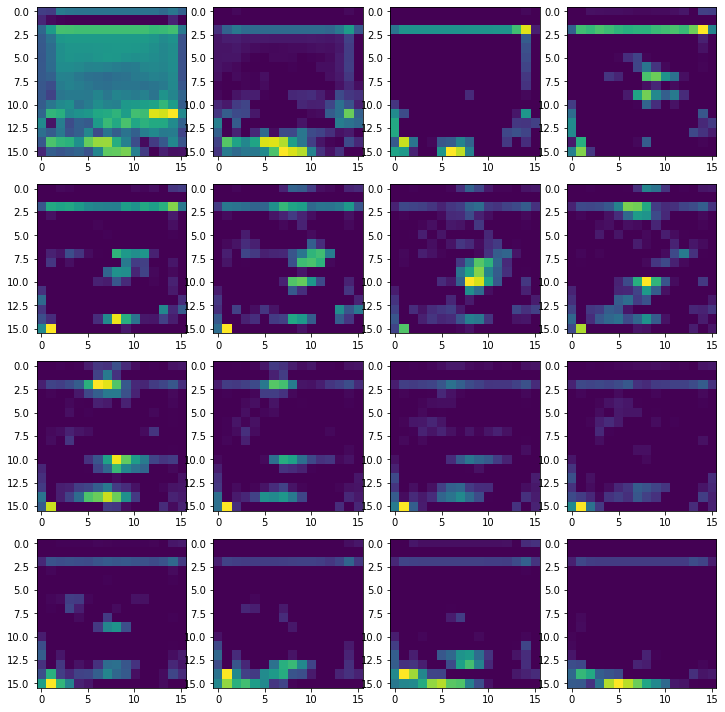

In [155]:
from matplotlib import pyplot as plt

# size of fourth layer ouput: (24, 16, 16, 16)

# Create figure and axes 
fig, axs = plt.subplots(4, 4, figsize=(10,10))
axs = axs.flatten() 

# Plot each data element on subplot
for i, ax in enumerate(axs):
    ax.imshow(fourth_downconv_output[0, 5, i])

fig.tight_layout()
plt.show()

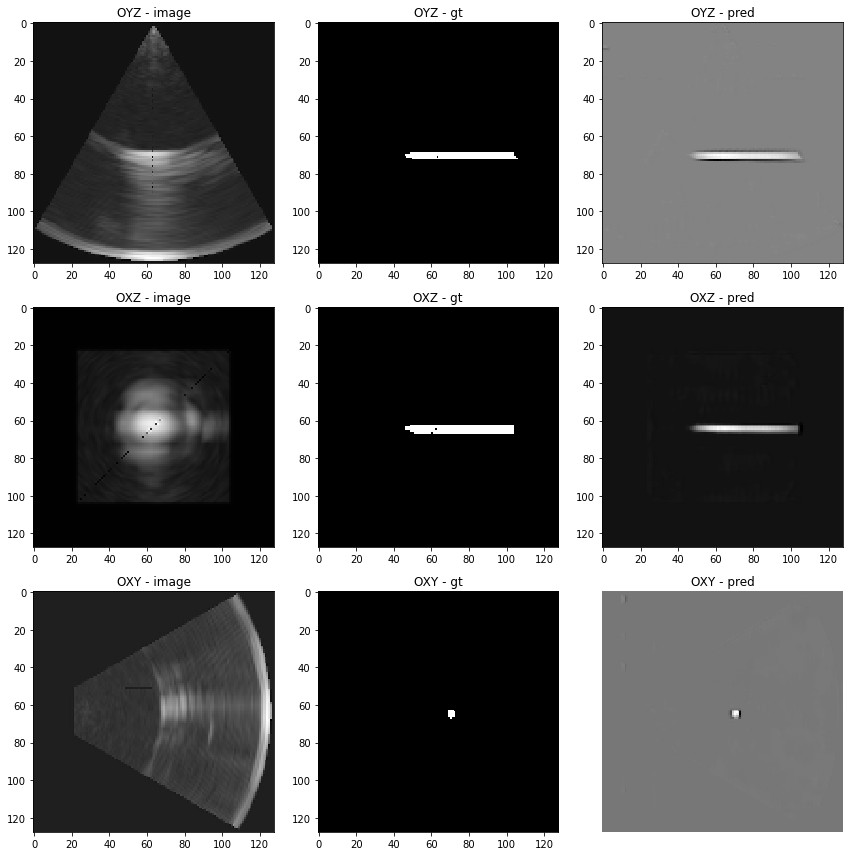

In [37]:
from utils.save_model_utils import save_sample_mask

save_sample_mask(0, 0, image[0], out[0], target, path = "", save = False)